# Titanic Dataset (Building a Binary Classification Model)
## Load the data
1. train.csv has features for age, sex, class, and survival rating from 0 to 1
2. test.csv has only features that we will use for predicting survival
3. train.shape tells us the passengers and features of dataset (891, 12)

In [20]:
import pandas as pd

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
gender_submission = pd.read_csv('/content/gender_submission.csv')

print(test.shape)
print(train.shape)

print(train.head())

(418, 11)
(891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500

## Exploration of Dataset <br>
Before we begin modeling, we must know the columns that are numerical vs categorical, which have missing data, and if the survival rate of the target is balanced or not.

In [21]:
train.info()
train.describe()
train["Survived"].value_counts() # Counts how many passengers survived vs. the one's who did not.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,count
Survived,
0,549
1,342


## Visualize the Data <br>
Helps us see patterns that models can learn from, and goes will with feature engineering.

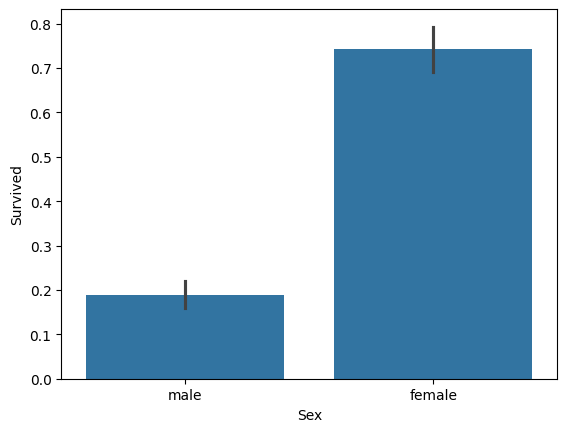

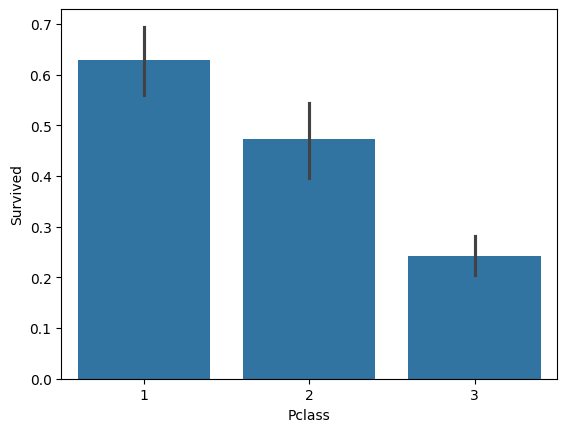

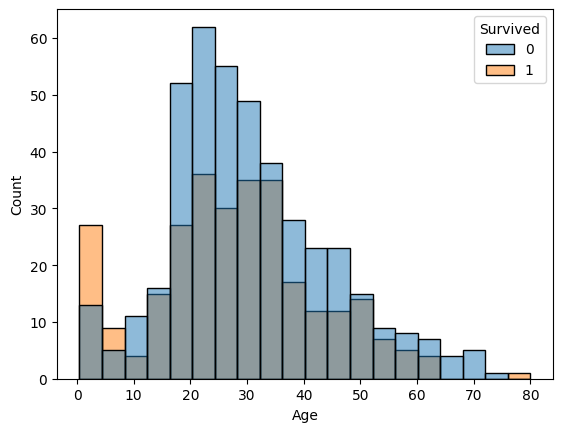

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

#Plotting average survival rate, ticket class, and age distributions of
# survivors and non-survivors

sns.barplot(x="Sex", y="Survived", data=train)
plt.show()

sns.barplot(x="Pclass", y="Survived", data=train)
plt.show()

sns.histplot(train, x="Age", hue="Survived", bins=20)
plt.show()

## Data Cleaning <br>
Missing values and categorical variables must be handled before ML can process them.

In [11]:
train["Age"].fillna(train["Age"].median(), inplace=True)
train["Embarked"].fillna(train["Embarked"].mode()[0], inplace=True)

# Encode sex as numbers, models can't process text directly.
train["Sex"] = train["Sex"].map({"male": 0, "female": 1})
test["Sex"] = test["Sex"].map({"male": 0, "female": 1})

test["Age"].fillna(test["Age"].median(), inplace=True)
test["Fare"].fillna(test["Fare"].median(), inplace=True)

/tmp/ipython-input-538208239.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["Age"].fillna(train["Age"].median(), inplace=True)
/tmp/ipython-input-538208239.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

## Feature Engineering <br>
Create new features in case they might carry signals that will be useful to us in the future for testing/training.

In [12]:
# Number of siblings/spouses along with parents and children aboard the ship
train["FamilySize"] = train["SibSp"] + train["Parch"]
test["FamilySize"] = test["SibSp"] + test["Parch"]

# Check to see if they were alone, means lower survival rates
train["IsAlone"] = (train["FamilySize"] == 0).astype(int)
test["IsAlone"] = (test["FamilySize"] == 0).astype(int)

## Defining our features and true target <br>
No need to worry about any other irrelevent data such as name, sex, cabin, ticket, etc <br>
Shift our priorities to only focus on the most useful data

In [13]:
features = ["Pclass", "Sex", "Age", "Fare", "FamilySize", "IsAlone", "Embarked"]

X = train[features]
y = train["Survived"]

# For testing our set features
X_test_final = test[features]

## Building the pipeline and training the model. <br>
1. Do this to handle preprocessing and modeling in one workflow
2. Numerical Pipeline to fill the missing values before scaling data
3. Categorical Pipeline to process non-numeric data
4. ColumnTransformer: applies the right pipeline to the right columns.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

num_attribs = ["Age", "Fare", "FamilySize"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

clf = Pipeline([
    ("prep", full_pipeline),
    ("log_reg", LogisticRegression(max_iter=200))
])

clf.fit(X, y)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare',
                                                   'FamilySize']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('log_reg', LogisticRegression(max_iter=200))])

## Evaluation of Model <br>
Testing multiple models to see the outcome of each

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
print("Cross Validation Accuracy:", scores.mean()) # Cross Validation splits data into 5 folds,
                                                  # trains on 4 of them, tests on 1 and repeats the process
clf = Pipeline([
    ("prep", full_pipeline),
    ("rf", RandomForestClassifier(n_estimators=200, random_state=42))
])

clf.fit(X, y)
scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
print("Random Forest CV accuracy:", scores.mean())

param_grid = {
    "rf__n_estimators": [100, 200, 500],
    "rf__max_depth": [None, 5, 10],
    "rf__min_samples_split": [2, 5, 10]
}

grid = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy")
grid.fit(X, y)

print("Best parameters:", grid.best_params_)
print("Best accuracy:", grid.best_score_)

Cross Validation Accuracy: 0.8025171050153789
Random Forest CV accuracy: 0.8025171050153789
Best parameters: {'rf__max_depth': 10, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Best accuracy: 0.8316615403929445


## Prediction Test Set

In [16]:
predictions = clf.predict(X_test_final)

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": predictions
})

submission.to_csv("submission.csv", index=False)